This notebook is used to unspect the gene body coverage of different bam files

In [98]:
import pysam
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

In [101]:
adata = sc.read_10x_mtx('/tmp/Mazutislab-out/Ignas/RT_comparison/25_SSCV_KG_04_S4_reads_with_tso/25_SSCV_KG_04_S4_reads_with_tso_Solo.out/Gene/filtered/', )

In [50]:
gtf = pysam.TabixFile("/tmp/Mazutislab-out/Ignas/RT_comparison/genome_and_annotations/gencode.v41.sorted.gtf.gz")
bams = {}
for i in range(1,5):
    bams[i] = pysam.AlignmentFile(f'/tmp/Mazutislab-out/Ignas/RT_comparison/25_SSCV_KG_0{i}_S{i}_reads_with_tso/25_SSCV_KG_0{i}_S{i}_reads_with_tso_Aligned.sortedByCoord.out.bam', 'rb')


In [58]:
gene_positions = {}
gene_strands = {}
gene_lengths = {}
for i, line in enumerate(open("/tmp/Mazutislab-out/Ignas/RT_comparison/genome_and_annotations/genes.gtf")):
    if 1 == 1: #for debugging
        line = line.split('\t')
        gene_id = line[8][9:31]
        if gene_id in gene_positions.keys():
            print('duplicate gene id')
            continue
        #print(line)
        gene_start_genomic = int(line[3])
        gene_end_genomic = int(line[4])
        gene_positions[gene_id] = (gene_start_genomic, gene_end_genomic)
        gene_lengths[gene_id] = gene_end_genomic - gene_start_genomic
        gene_strands[gene_id] = line[6]
        #print(gene_strands[gene_id])
        #print(gene_positions[gene_id])
    

In [51]:
print(bams[4].fetch())

In [62]:
collected_data = {}
for i, bam in bams.items():
    collected_data[i] = {}
    #print(bam)
    distances_to_3_prime_end = []
    distances_to_5_prime_end = []
    distances_to_3_prime_end_normalized = []
    n_reads = 0
    for j,read in tqdm.tqdm(enumerate(bam.fetch())):
        #print(read)
        gene_id = read.get_tag('GX')
        if gene_id in gene_positions.keys():
              gene_strand = gene_strands[gene_id]
        else:
              continue
        #print(gene_id)
        if read.is_reverse:
                if gene_strand == '+':
                      print("mismatch between read and gene strand")
                      continue
                read_start = read.reference_end
                read_end = read.reference_start
                gene_start, gene_end = gene_positions[gene_id][1], gene_positions[gene_id][0]       
        else:
                if gene_strand == '-':
                      print("mismatch between read and gene strand")
                      continue
                read_start = read.reference_start
                read_end = read.reference_end
                gene_start, gene_end = gene_positions[gene_id]
        n_reads += 1
        gene_length = gene_lengths[gene_id]
        distances_to_3_prime_end.append(abs(read_start - gene_start))
        distances_to_5_prime_end.append(abs(gene_end - read_start))
        distances_to_3_prime_end_normalized.append(distances_to_3_prime_end[-1]/gene_length)
    collected_data[i]['n_reads'] = n_reads
    collected_data[i]['distances_to_3_prime_end'] = distances_to_3_prime_end
    collected_data[i]['distances_to_5_prime_end'] = distances_to_5_prime_end
    collected_data[i]['distances_to_3_prime_end_normalized'] = distances_to_3_prime_end_normalized

271641it [00:01, 266881.45it/s]
151921it [00:00, 239722.26it/s]
290433it [00:01, 264989.65it/s]
9216193it [00:30, 304833.48it/s]


In [63]:
for i in range(1,5):
    print(f'Sample {i}:')
    print(f'Number of reads: {collected_data[i]["n_reads"]}')
    print(f'Mean distance to 3\' end: {sum(collected_data[i]["distances_to_3_prime_end"])/len(collected_data[i]["distances_to_3_prime_end"])}')
    print(f'Mean distance to 5\' end: {sum(collected_data[i]["distances_to_5_prime_end"])/len(collected_data[i]["distances_to_5_prime_end"])}')
    print(f'Mean normalized distance to 3\' end: {sum(collected_data[i]["distances_to_3_prime_end_normalized"])/len(collected_data[i]["distances_to_3_prime_end_normalized"])}')

Sample 1:
Number of reads: 64148
Mean distance to 3' end: 18043.94179085864
Mean distance to 5' end: 10485.248721706055
Mean normalized distance to 3' end: 0.5510614570504657
Sample 2:
Number of reads: 38412
Mean distance to 3' end: 17822.446579194002
Mean distance to 5' end: 11631.197490367593
Mean normalized distance to 3' end: 0.5123981098257511
Sample 3:
Number of reads: 65623
Mean distance to 3' end: 17855.23603005044
Mean distance to 5' end: 9971.358913795468
Mean normalized distance to 3' end: 0.581479450239061
Sample 4:
Number of reads: 1991434
Mean distance to 3' end: 21268.214337507547
Mean distance to 5' end: 10930.064791502004
Mean normalized distance to 3' end: 0.5762482606563933


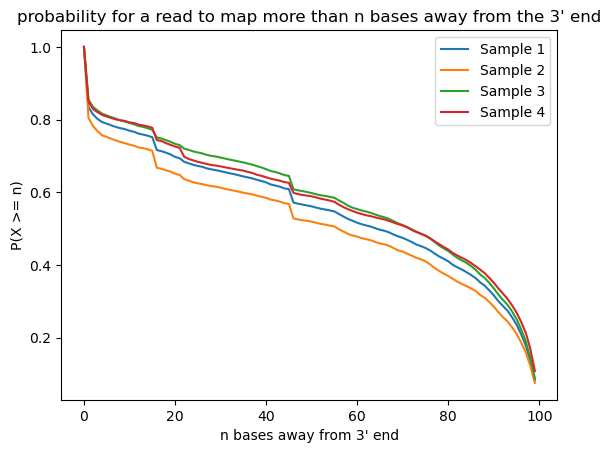

In [94]:
data = {}
for i in range(1,5):
    distances_to_3_prime_end_normalized = collected_data[i]['distances_to_3_prime_end_normalized']
    data[i] = np.histogram(distances_to_3_prime_end_normalized, bins = 100)[0] / len(distances_to_3_prime_end_normalized)
for i in range(1,5):
    plt.plot(np.flip(np.cumsum(np.flip(data[i]))), label=f'Sample {i}')


plt.title("probability for a read to map more than n bases away from the 3' end")
plt.xlabel("n bases away from 3' end")
plt.ylabel("P(X >= n)")
plt.legend()

/tmp/ipykernel_33443/2807425232.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distances_to_3_prime_end_normalized = pd.concat([distances_to_3_prime_end_normalized, pd.DataFrame(data = {'sample' : sample_ids, 'distance' : distances})], axis = 0)


<Axes: xlabel='distance', ylabel='Density'>

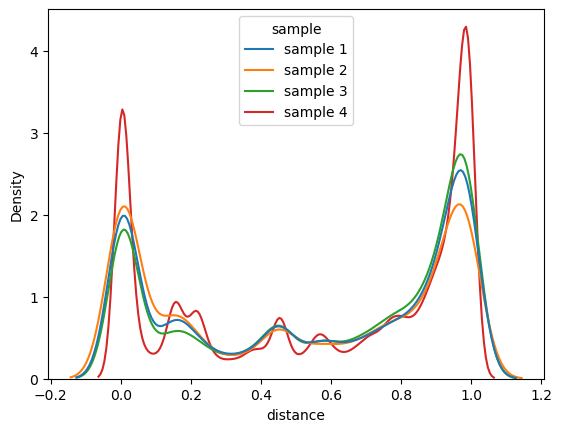

In [92]:
import seaborn as sns
import pandas as pd
#distances_to_3_prime_end_normalized = {}

distances_to_3_prime_end_normalized = pd.DataFrame(columns=['sample', 'distance'])
for i in range(1,5):
    distances = collected_data[i]['distances_to_3_prime_end_normalized']
    sample_ids = [f'sample {i}' for j in range(len(distances))]
    distances_to_3_prime_end_normalized = pd.concat([distances_to_3_prime_end_normalized, pd.DataFrame(data = {'sample' : sample_ids, 'distance' : distances})], axis = 0)
sns.kdeplot(data = distances_to_3_prime_end_normalized, x = 'distance', hue = 'sample', common_norm = False)



In [ ]:
#for i in range(1,5):
    #distances_to_3_prime_end_normalized[i] = collected_data[i]['distances_to_3_prime_end_normalized']
#sns.displot(data=distances_to_3_prime_end_normalized, kind="kde")
'''
data = {}
for i in range(1,5):
    distances_to_3_prime_end_normalized = collected_data[i]['distances_to_3_prime_end_normalized']
    data[i] = np.histogram(distances_to_3_prime_end_normalized, bins = len(distances_to_3_prime_end_normalized))[0] / len(distances_to_3_prime_end_normalized)
for i in range(1,5):
    #plt.plot(np.flip(np.cumsum(np.flip(data[i]))), label=f'Sample {i}')
    plt.hist(distances_to_3_prime_end_normalized, bins=100, density=True, histtype='step', cumulative=-1, label=f'Sample {i}')


plt.title("probability for a read to map more than n bases away from the 3' end")
plt.xlabel("n bases away from 3' end")
plt.ylabel("P(X >= n)")
plt.legend()
'''

In [25]:
len(gene_positions)

37733

In [4]:
fasta.fetch(region=)

SyntaxError: expected argument value expression (3702462868.py, line 1)